# Example OpenTISim with OpenCLSim for Export - Import Terminal 

## 0. Import packages and initialise objects

### Import Packages

In [1]:
### import datetime, time
import numpy as np
import numpy.matlib as npml
import pandas as pd
import statistics as st
from copy import deepcopy

import networkx as nx
import simpy

import matplotlib.pyplot as plt
from simplekml import Kml, Style   # for graph_kml
import math

import shapely.geometry
import pyproj

import pandas as pd
from opentisim.liquidbulk.hydrogen_defaults import *
from opentisim.liquidbulk.hydrogen_objects import *
import opentisim

# OpenCLSim
import openclsim
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

### Initialise Supply Chains, objects and transport modes

In [2]:
class SupplyChain:
    """This class implements a 'supply chain'.
    - name: supplychain name
    - origin: geometry indicating the origin
    - destination: geometry indicating the destination
    - elements: list of objects that can be used to transport goods (vessels, trucks, etc)
    - modal split: indicating a split
    """

    def __init__(self, 
                 name='Supply chain',
                 elements=[],
                 origin='from_site',
                 origin_latent_demand = 0,
                 origin_online_throughput = 0,
                 destination='mid_site',
                 destination_latent_demand = 0,
                 destination_online_throughput = 0,
                 capacity=None,
                 condition=[],
                 modalsplit=None
                 ):
        # identity
        self.name = name

        # collection of all terminal objects
        self.elements = elements

         # time inputs
        self.origin = origin
        self.origin_latent_demand = origin_latent_demand
        self.origin_online_throughput = origin_online_throughput
        self.destination = destination
        self.destination_latent_demand = destination_latent_demand
        self.destination_online_throughput = destination_online_throughput
        self.capacity = capacity
        self.condition = condition
        self.modalsplit = modalsplit

#### Create Site, Transport and Boil-off objects 

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.Locatable,
        openclsim.core.HasContainer,
        openclsim.core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        openclsim.core.LoadingFunction,
        openclsim.core.UnloadingFunction,
    ),
    {},
)

BoiloffResource = type(
    "Boil-off",
    (
        openclsim.core.Identifiable,
        openclsim.core.Log,
        openclsim.core.ContainerDependentMovable,
        openclsim.core.Processor,
        openclsim.core.HasResource,
        #openclsim.core.LoadingFunction,
        #openclsim.core.UnloadingFunction,
    ),
    {},
)

## 1. Initiate simulation

for year in years:

* Step 1.1: Prepare Model set-up
    * Step 1.1.1.: Prepare graph (choose origin and destination) 
    * Step 1.1.2.: Choose Carrier and model time
* Step 1.2: Add properties to the graph
    * Step 1.2.1: Assign throughput scenarios to nodes
    * Step 1.2.2: Assign OpenTISim terminal elements to nodes
    * Step 1.2.3: Identify active supply chains
* Step 1.3: Step through years, and through the active supply chains
    * First we make terminal simulations
    * Next we attempt to simulate logistics with OpenCLSim (using storage capacities from OpenTISim) 

### 1.1 Prepare Model set-up

#### 1.1.1. Prepare graph 

Find the coordinates with a specific distance

In [4]:
#distance between export and import = 1000 km 
#coordinates import terminal =  (4.268813386454553,51.88121982094231)

phi =  51.88121982094231 #latitude import
lamb = 4.268813386454553 #longitude import  

phirad = phi * np.pi / 180
lambrad = lamb*np.pi / 180

theta = 10 #bearing 
thetarad = theta * np.pi / 180

d =  1000 #1000 #km distance 
R =  6371 #km earths radius 
delta = d/R #angular distance 

import math

lat2 = math.asin(math.sin(phirad)*math.cos(d/R) + math.cos(phirad)*math.sin(d/R)*math.cos(thetarad))
phirad2 = lat2
lon2 = lambrad + math.atan2(math.sin(thetarad)*math.sin(d/R)*math.cos(phirad), 
                           math.cos(d/R)-math.sin(phirad)*math.sin(phirad2))


londeg = lon2 * 180 / np.pi
latdeg = lat2 * 180 / np.pi
print(latdeg)
print(londeg)

60.70233149082849
7.448663050360107


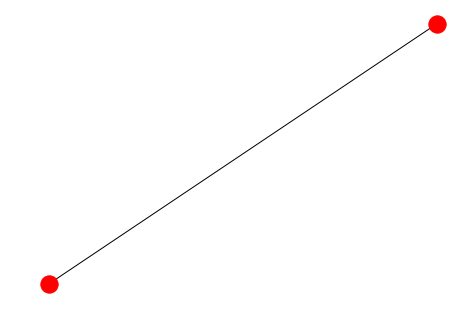

In [5]:
# path as clicked with Google Earth

# path = [(-8.887295356404051,37.94869396789168), # Sines PT
#         (4.268813386454553,51.88121982094231)] # Botlek NL 

path = [(londeg, latdeg), # 1000 km 
        (4.268813386454553,51.88121982094231)] # Botlek NL 

# convert clicked path to networkx graph and draw
FG, positions, names = opentisim.core.convert_path_to_graph(path)
nx.draw(FG, positions)
FG.nodes

origin = shapely.geometry.Point(londeg, latdeg)
destination = shapely.geometry.Point(4.268813386454553,51.88121982094231)

# inspect graph on Google Earth
# graph_kml(
#     FG,
#     fname="supplychain.kml")

In [6]:
# Using 'path' the graph's nodes are automatically named: 'node-0', 'node-1', 'node-2', etc. Lets rename:

# prepare mapping
mapping = {
    'node-0':'from_site',  # from node
    'node-1':'mid_site',  # mid node 
          }

# apply mapping to graph object
FG = nx.relabel_nodes(FG, mapping)
FG.nodes

NodeView(('from_site', 'mid_site'))

#### 1.1.2. Choose carrier and model time 

input parameters:
- startyear 
- modelperiod 
- carrier 
- decentralized vs. centralized 
- transport mode between export and import = vessel 
- demand hydrogen

In [7]:
startyear = 2020
lifecycle = 10 
years = list(range(startyear, startyear+lifecycle))
carrier = 'liquid hydrogen'
place = 'decentralized'
transport_sc1 = 'vessel'

demand_hydrogen = 2_000_000

if place == 'decentralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage'}
if place == 'centralized':
    sc_export = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_conversion'}
    sc_import = {'berth_jetty','pipeline_jetty_-_terminal', 'storage', 'h2_retrieval'}

In [8]:
if carrier == 'liquid hydrogen':
    commodity_type_defaults = commodity_lhydrogen_data
    storage_type_defaults = storage_lh2_data
    h2conversion_type_defaults = h2conversion_lh2_data
    h2retrieval_type_defaults = h2retrieval_lh2_data
    vessel_defaults = largehydrogen_data
        
if carrier == 'ammonia':
    commodity_type_defaults = commodity_ammonia_data
    storage_type_defaults = storage_nh3_data
    h2conversion_type_defaults = h2conversion_nh3_data
    h2retrieval_type_defaults = h2retrieval_nh3_data
    vessel_defaults = largeammonia_data

if carrier == 'MCH':
    commodity_type_defaults = commodity_MCH_data
    storage_type_defaults = storage_MCH_data
    h2conversion_type_defaults = h2conversion_MCH_data
    h2retrieval_type_defaults = h2retrieval_MCH_data
    vessel_defaults = vlcc_data

##### Find all shipping routes defaults

Find parameters of the shipping route between the export and import terminal:
- distance (in km)
- trip duration (in days) 
- maximum that one vessel can carry in 1 year (in ton carrier) 
- loss of load (in %)
- loss of load (in ton carrier) 
- number of trips of 1 vessel in 1 year 


In [9]:
def character_shippingroute(origin, destination, vessel_defaults):
    capacity_ship = vessel_defaults["call_size"]
    pump_ship = vessel_defaults["pump_capacity"]
    loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
    velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
    losses_ship = vessel_defaults['losses']
    
    wgs84 = pyproj.Geod(ellps="WGS84")
    orig = shapely.geometry.asShape(origin)
    dest = shapely.geometry.asShape(destination)
    _, _, distance = wgs84.inv(orig.x, orig.y, dest.x, dest.y) #distance in m 
    
    v = lambda x: velocity_ship #default: ship velocity in m/s 
    current_speed = v 
    loading = loadingtime_ship  #default: ship loading time #in seconds: 
    unloading = unloadingtime_ship #default: ship unloading time
    
    capacity_ship = capacity_ship  #default: ship capacity 
    secyear = 60*60*24*365
    
    engine_order = 1 
    duration = distance/((current_speed) (engine_order))
    
    distancekm = distance/1000
    durationdays = duration/60/60/24
    #print(distance/1000, 'distance in km')
    #print(duration/60/60/24, 'in days')
    
    onetriptime = loading + duration + unloading + duration 
    numberoftrips = math.ceil(secyear / onetriptime)#6  #7.48 #math.ceil(secyear / onetriptime)
    maxtrans1 = numberoftrips * capacity_ship 
    
    #print(maxtrans1, 'maximum volume that can be transferred from from_site to mid_site') #1019700 max trans for origin to midsite 

    bog = losses_ship #%/d default
    ton = capacity_ship #ton LH2 default 

    days = math.ceil(durationdays) #math.ceil math.floor

    bogtot = np.zeros(days)
    bogtot[0] = ton*(100-bog)/100

    for i in range(days-1):
        bogtot[i+1] = bogtot[i] - ((bog*bogtot[i])/100) 
        
    totloss = 100-((100*bogtot[-1])/ton)
    transloss = totloss
    #print(transloss)

    lossofload = ton - ((100-transloss)*ton/100)
    #print(lossofload)
    
    return distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips

In [10]:
distancekm, durationdays, maxtrans1, transloss, lossofload,numberoftrips = character_shippingroute(origin, destination, vessel_defaults)

print('the number of trips is', numberoftrips)
print('distance origin to destination is', distancekm, 'km')
print('duration of 1 trip is', durationdays, 'days')
print('1 ship can transfer a maximum of', maxtrans1, 'ton of', carrier, 'in 1 year')
print('1 ship has a transport loss of', transloss, '%, which is equal to', lossofload, 'ton of', carrier, 'per trip')

the number of trips is 83
distance origin to destination is 1001.4399160468696 km
duration of 1 trip is 1.6690665267447826 days
1 ship can transfer a maximum of 1567538 ton of liquid hydrogen in 1 year
1 ship has a transport loss of 0.5990999999999929 %, which is equal to 113.14602599999853 ton of liquid hydrogen per trip


##### Find losses

In [11]:
jetty_loss = jetty_pipeline_data['losses']
recplant_loss = h2retrieval_type_defaults['losses']
conplant_loss = h2conversion_type_defaults['losses']
storage_loss = storage_type_defaults['losses']*30
transport_loss = transloss 
Hcontent = commodity_type_defaults['Hcontent']

### 1.2 Add properties to the graph
#### 1.2.1 Assign throughput scenarios to nodes

In [12]:
nx.set_node_attributes(FG, [], 'througput')

#### 1.2.2 Calculate the Supply and Demand

For the specific carrier the supply and demand is given in tonnes of carrier. 
The supply is based on the demand and the demand is given in ton H2. 
For a carrier the demand needs to be converted from hydrogen to carrier. 
The supply needs to be converted for the demand with the added losses. 

In [13]:
#demand at end-user is 2,000,000 H2 
#place of plant is decentralized 
if place == 'decentralized':
     #give the Demand that you need in tonnes of H2 
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = demand_carrier1
    demand_import_in = (((jetty_loss+storage_loss)+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss)+100)*demand_carrier1)/100

if place == 'centralized':
    #give the Demand that you need in tonnes of H2 
    demand_carrier1 = (demand_hydrogen * 100) / Hcontent #demand is converted to carrier 

    #import terminal is dimensioned on this demand plus losses (import terminal out)
    demand_import_out = demand_carrier1
    demand_import_in = (((jetty_loss+storage_loss+ recplant_loss )+100)*demand_carrier1)/100

    #export terminal is dimensioned on this demand plus losses (export terminal out)
    demand_export_out = (((transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100
    demand_export_in = (((conplant_loss + storage_loss + jetty_loss + transloss+jetty_loss+storage_loss + recplant_loss)+100)*demand_carrier1)/100

    #print(demand_enduse_out)
    #print(demand_export_in )
print(demand_carrier1, 'demand in carrier') 
print(demand_import_in, 'demand import terminal in')
print(demand_import_out, 'demand import terminal out')

print(demand_export_in, 'demand export terminal in')
print(demand_export_out, 'demand export terminal out')

2000000.0 demand in carrier
2036000.0 demand import terminal in
2000000.0 demand import terminal out
2083981.9999999998 demand export terminal in
2047981.9999999998 demand export terminal out


######  from_site: create and add a supply throughput 

The export terminal is dimensioned on the demand that has to go in to the vessel. 

In [14]:
# create a supply at the from_site
#supply = list(np.matlib.repmat(2_036_000,1,len(years))[0])

supply = []
for year in years:
    if year < 2025:
        supply.append(demand_export_out) #(2_000_000 H2)
    else:
        supply.append(demand_export_out) #(4_000_000 H2)
        
throughput_from = pd.DataFrame({'year': years, 
                     'volume': supply})
print(throughput_from)
FG.nodes['from_site']['througput'] = throughput_from

# print('Positive throuput is supply, negative throughput is demand')
# display(througput_from)

   year     volume
0  2020  2047982.0
1  2021  2047982.0
2  2022  2047982.0
3  2023  2047982.0
4  2024  2047982.0
5  2025  2047982.0
6  2026  2047982.0
7  2027  2047982.0
8  2028  2047982.0
9  2029  2047982.0


######  mid_site: create and add a demand throughput 

The import terminal is dimensioned on the demand that has to come out of the reconversion plant (converted to carrier).  

In [15]:
# create a demand at the mid_site
# demand = list(npml.repmat(2_000_000,1,len(years))[0])

demand = []
for year in years:
    if year < 2025:
        demand.append(demand_import_out) #(2_000_000 H2)
    else:
        demand.append(demand_import_out) #(4_000_000 H2)
        
#demand = list(npml.repmat(20_000_000,1,len(years))[0])
throughput_mid = pd.DataFrame({'year': years, 
                     'volume': demand})

print(throughput_mid)
FG.nodes['mid_site']['througput'] = throughput_mid

# print('Positive throuput is supply, negative throughput is demand')
# display(throughput_end)

   year     volume
0  2020  2000000.0
1  2021  2000000.0
2  2022  2000000.0
3  2023  2000000.0
4  2024  2000000.0
5  2025  2000000.0
6  2026  2000000.0
7  2027  2000000.0
8  2028  2000000.0
9  2029  2000000.0


#### 1.2.2 Assign terminal objects to nodes

In [16]:
# add an empty terminal property
nx.set_node_attributes(FG, [], 'terminal')

# add an empty OpenCLSim Site property
nx.set_node_attributes(FG, [], 'site')

###### From_site:
instantiate demand

In [17]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_from
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_from  #choose what carrier
    demand = [ammonia] 
    
if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_from  #choose what carrier
    demand = [MCH] 

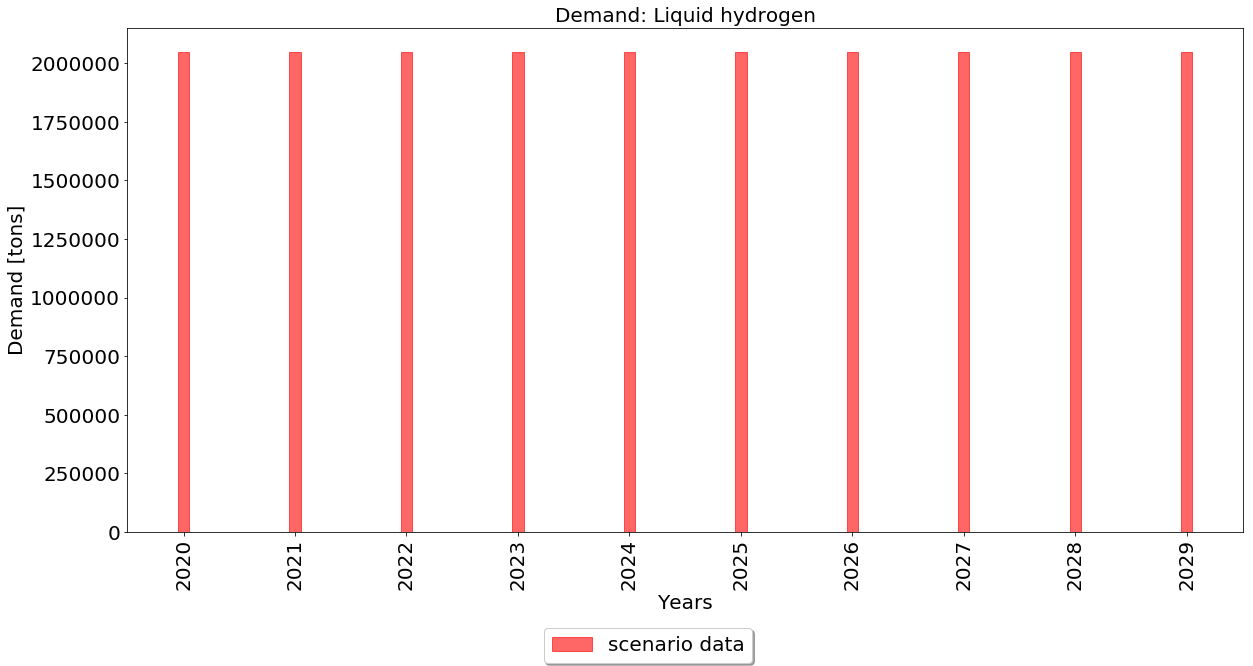

In [18]:
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

In [19]:
# instantiate vessels
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

##### From_site: Instantiate Export Terminal

In [20]:
if carrier == 'MCH':
    dwelltime =45/365
else:
    dwelltime = 30/365
    
# Instantiate OpenTISim Terminal
from_site_terminal = opentisim.liquidbulk.ExportTerminal(
            startyear = None, 
            lifecycle = 1, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_export,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2conversion_type_defaults=h2conversion_type_defaults,
            allowable_dwelltime= dwelltime)

from_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
from_site_terminal.revenues = []
from_site_terminal.demurrage = []

# add an OpenTNSim Terminal to the graph
FG.nodes['from_site']['terminal'] = from_site_terminal

##### Mid_site: 

Instantiate Demand

In [21]:
if carrier == 'liquid hydrogen':
    commodity_lhydrogen_data['smallhydrogen_perc'] = 0
    commodity_lhydrogen_data['largehydrogen_perc'] = 100
    commodity_lhydrogen_data['historic_data'] = []
    commodity_lhydrogen_data['scenario_data'] = []
    lhydrogen = Commodity(**commodity_lhydrogen_data)
    lhydrogen.scenario_data = throughput_mid
    demand = [lhydrogen] 
    
if carrier == 'ammonia':
    commodity_ammonia_data["smallammonia_perc"] = 0
    commodity_ammonia_data["largeammonia_perc"] = 100
    commodity_ammonia_data['historic_data'] = []
    commodity_ammonia_data['scenario_data'] = []
    ammonia = Commodity(**commodity_ammonia_data)
    ammonia.scenario_data = throughput_mid  #choose what carrier
    demand = [ammonia] 

if carrier == 'MCH':
    commodity_MCH_data["handysize_perc"] = 0
    commodity_MCH_data["panamax_perc"] = 0
    commodity_MCH_data["vlcc_perc"] = 100
    commodity_MCH_data['historic_data'] = []
    commodity_MCH_data['scenario_data'] = []
    MCH = Commodity(**commodity_MCH_data)
    MCH.scenario_data = throughput_mid  #choose what carrier
    demand = [MCH] 



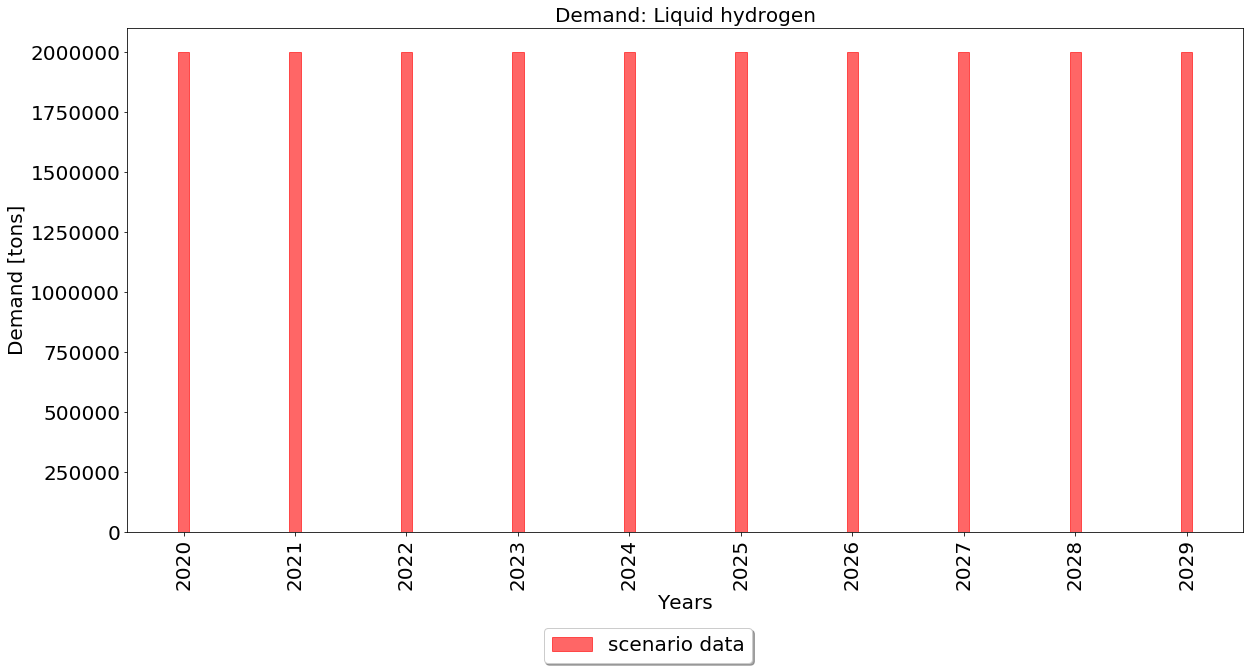

In [22]:
if carrier == 'liquid hydrogen':
    lhydrogen.plot_demand()
    
if carrier == 'ammonia':
    ammonia.plot_demand()
    
if carrier == 'MCH':
    MCH.plot_demand()

In [23]:
# instantiate vessels
Smallhydrogen = Vessel(**smallhydrogen_data)
Largehydrogen = Vessel(**largehydrogen_data)
Smallammonia = Vessel(**smallammonia_data)
Largeammonia = Vessel(**largeammonia_data)
Handysize = Vessel(**handysize_data)
Panamax = Vessel(**panamax_data)
VLCC = Vessel(**vlcc_data)

# vessels variable: contains info on vessels (to be added to Terminal.elements)
vessels = [Smallhydrogen, Largehydrogen, Smallammonia, Largeammonia, Handysize, Panamax, VLCC] 

##### Mid_site: Instantiate Import Terminal

In [24]:
if carrier == 'MCH':
    dwelltime = 45/365
else:
    dwelltime = 30/365

# Instantiate OpenTNSim Terminal
mid_site_terminal =  opentisim.liquidbulk.System(
            startyear = None, 
            lifecycle = 1, 
            elements = demand + vessels, 
            operational_hours = 16*365,   # example Wijnand
            terminal_supply_chain=sc_import,
            debug=False,
            commodity_type_defaults=commodity_type_defaults,
            storage_type_defaults=storage_type_defaults,
            kendall='E2/E2/n',
            allowable_waiting_service_time_ratio_berth=0.3,
            h2retrieval_type_defaults=h2retrieval_type_defaults,
            allowable_dwelltime= dwelltime)


mid_site_terminal.modelframe = list(range(startyear, startyear + lifecycle))
mid_site_terminal.revenues = []
mid_site_terminal.demurrage = []

# add an OpenTNSim Terminal to the graph
#FG.nodes['from_site']['terminal'] = from_site_terminal

# add an OpenTNSim Terminal to the graph
FG.nodes['mid_site']['terminal'] = mid_site_terminal

#### 1.2.3 Identify active supply chains

In [25]:
supplychain_1 = SupplyChain(
    name='Supplychain 1',
    elements = [],
    origin = 'from_site',
    origin_latent_demand = 0,
    origin_online_throughput = 0,
    destination='mid_site',
    destination_latent_demand = 0,
    destination_online_throughput = 0,
    condition=[{"type": "container", "concept": 'from_site', "state": "empty"}],
    capacity=None)

In [26]:
supplychains = [supplychain_1]

#### Find ship characteristics

In [27]:
capacity_ship = vessel_defaults["call_size"]
pump_ship = vessel_defaults["pump_capacity"]
loadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
unloadingtime_ship = ((vessel_defaults["call_size"]/vessel_defaults["pump_capacity"]) +vessel_defaults["mooring_time"])*60*60
velocity_ship = vessel_defaults['avspeed']/3.6 # #25 km/h --> m/s 
losses_ship = vessel_defaults['losses']

if carrier == 'MCH':
    loadingtime_ship = 2*loadingtime_ship
    unloadingtime_ship = 2*unloadingtime_ship



# Run Terminals and Transport

This code runs the export and import terminal for each year and it shows how many vessels are needed each year to empty the from_site

In [28]:
Debug = False
debug = True

commodity_lhydrogen_data['scenario_data'] = []
commodity_ammonia_data['scenario_data'] = []
commodity_MCH_data['scenario_data'] = []
dataframe_openclsim = []

startyear = 2020
lifecycle = 10 

years = list(range(startyear, startyear+lifecycle))
years1 =  list(range(startyear, startyear+lifecycle))
years2 = list(range(startyear+2,startyear+lifecycle))


for index_year,year in enumerate(years):
    for supplychain in supplychains:
        count_vessel = 0 
        FG.nodes[supplychain.origin]['site'] = []
        FG.nodes[supplychain.destination]['site'] = []
    # OpenTISim: op 1 januari neem je al je beslissingen (terminals + supply chains)
    if debug == True:
        print('')
        print('simulation for year: {} ---------------'.format(year))
    
    for supplychain in supplychains:
        # 1. als de origin node in de supplychain een throughput property heeft, 
        # bereken dan de benodigde terminal dimensies
        throughput_online_origin = 0
        if type(FG.nodes[supplychain.origin]['througput']) == pd.core.frame.DataFrame:
            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            #FG.nodes[supplychain.origin]['terminal'].years = years1
            #print(FG.nodes[supplychain.origin]['terminal'].__dict__)
            FG.nodes[supplychain.origin]['terminal'].simulate()
            
            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
    
            if debug == True:
                print('Terminal: {}, year: {}, throughput online: {}'.format(supplychain.origin, year, throughput_online_origin))
                print('')
                print()

            #supplychain.origin_online_throughput = throughput_online_jetty_origin
            supplychain.origin_online_throughput = throughput_online_origin
            
         # 2. als de destination node in de supplychain een throughput property heeft, 
        # bereken dan de benodigde terminal dimensies
        throughput_online_destination = 0
        if type(FG.nodes[supplychain.destination]['througput']) == pd.core.frame.DataFrame:
            
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            #FG.nodes[supplychain.destination]['terminal'].years = years1
            FG.nodes[supplychain.destination]['terminal'].simulate()
            
            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_destination))
                print('')
            
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
        # 3. als de origin een throughput heeft, maar de destination niet,
        # voeg dan de throughput van de origin toe aan die van de destination 
        if throughput_online_origin != 0 and throughput_online_destination == 0:
            if debug == True:
                print('The origin is generating throughput. I need a latent demand in the destination location.')

#             The origin is generating throughput. I need a latent demand in the destination location.
#             Terminal: mid_site, year: 2004, throughput: 1617850.649350649

            #supplychain.destination_latent_demand = throughput_online_jetty_origin
            supplychain.destination_latent_demand = throughput_online_origin

            # Use the throughput at the other end of the supply chain as a latent demand

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []
                lhydrogen = Commodity(**commodity_lhydrogen_data)
                lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                demand = [lhydrogen]
                #print(lhydrogen.scenario_data)
            

            # Ammonia
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                ammonia = Commodity(**commodity_ammonia_data)
                ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                demand = [ammonia]

            # MCH
            if carrier == 'MCH': 
                commodity_MCH_data['historic_data'] = []
                MCH = Commodity(**commodity_MCH_data)
                MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_origin})
                MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                demand = [MCH]

            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.destination]['terminal'].elements = terminal_elements + demand + vessels
            
            FG.nodes[supplychain.destination]['terminal'].startyear = year
            FG.nodes[supplychain.destination]['terminal'].debug = Debug
            FG.nodes[supplychain.destination]['terminal'].years = years2
            FG.nodes[supplychain.destination]['terminal'].simulate()

            throughput_online_destination, throughput_terminal_in,throughput_online_jetty_in_dest, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.destination, year, throughput_online_jetty_destination))
                print('')
            
            #supplychain.destination_online_throughput = throughput_online_jetty_destination
            supplychain.destination_online_throughput = throughput_online_jetty_in_dest
            
            
        # 4. als de origin geen throughput heeft, maar de destination wel,
        # voeg dan de throughput van de destination toe aan die van de origin 
        if throughput_online_origin == 0 and throughput_online_destination != 0:
            if debug == True:
                print('The destination is generating throughput. I need latent demand in the origin location')
            
            supplychain.origin_latent_demand = throughput_online_jetty_in_dest #throughput_online_jetty_destination

            # Use the throughput at the other end of the supply chain as a latent demand
            supply = list(np.matlib.repmat(throughput_online_jetty_destination,1,1)[0])
            througput_origin = pd.DataFrame({'year': year, 'volume': supply})

            # Liquid hydrogen
            if carrier == 'liquid hydrogen':
                commodity_lhydrogen_data['historic_data'] = []
                #lhydrogen = hydrogen_objects.Commodity(**hydrogen_defaults.commodity_lhydrogen_data)

                if lhydrogen.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    lhydrogen.scenario_data = lhydrogen.scenario_data
                    #print('true')
                else:
                    lhydrogen.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    lhydrogen.scenario_data = pd.DataFrame(lhydrogen.scenario_data)
                    #print('false')
                demand = [lhydrogen]
            
            if carrier == 'ammonia':
                commodity_ammonia_data['historic_data'] = []
                if ammonia.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    ammonia.scenario_data = ammonia.scenario_data
                    #print('true')
                else:
                    ammonia.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    ammonia.scenario_data = pd.DataFrame(ammonia.scenario_data)
                    #print('false')
                demand = [ammonia]
            
            if carrier == 'MCH':
                commodity_MCH_data['historic_data'] = []
                if MCH.scenario_data['volume'].values[-1] > throughput_online_jetty_destination:
                    MCH.scenario_data = MCH.scenario_data
                    #print('true')
                else:
                    MCH.scenario_data.append({'year': year, 'volume': throughput_online_jetty_destination}) #xxx
                    MCH.scenario_data = pd.DataFrame(MCH.scenario_data)
                    #print('false')
                demand = [MCH]
                    
            
            # adopt vessels from the other node
            vessels = [x for x in FG.nodes[supplychain.destination]['terminal'].elements if type(x) == Vessel]
            
            # find all terminal_elements that are NOT a commodity
            terminal_elements = [x for x in FG.nodes[supplychain.origin]['terminal'].elements if type(x) != Commodity and type(x) != Vessel]

            # add terminal_elements + new demands
            FG.nodes[supplychain.origin]['terminal'].elements = terminal_elements + demand + vessels

            FG.nodes[supplychain.origin]['terminal'].startyear = year
            FG.nodes[supplychain.origin]['terminal'].debug = Debug
            FG.nodes[supplychain.origin]['terminal'].years = years2
            FG.nodes[supplychain.origin]['terminal'].simulate()

            throughput_online_origin, throughput_terminal_in,throughput_online_jetty_in, throughput_online_stor_in, throughput_online_plant_in, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
            
            if debug == True:
                print('Terminal: {}, year: {}, throughput: {}'.format(supplychain.origin, year, throughput_online_jetty_origin))
                print('')

            supplychain.origin_online_throughput = throughput_online_origin
    
    # 5. run openclsim calculation
    # OpenCLSim: tussen 2 januari - 31 december ga je transporteren
    if supplychain.origin_online_throughput !=0 and supplychain.destination_online_throughput!=0:

        # step past all supplychains to initiate the sites and vessels
        for index, supplychain in enumerate(supplychains):
            
            if index == 0:
                #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                level_from_site = supplychain.origin_online_throughput
                level_to_site = 0
                #activities = []
                while level_from_site != 0:
                    count_vessel += 1
                    if debug == True:
                        print('**Add a ship**')
                    #make environment 
                    #simulation_start  = datetime.datetime(year, 1, 1, 0, 0)
                    #my_env = simpy.Environment(initial_time=simulation_start.timestamp())
                    simulation_start = 0 
                    my_env = simpy.Environment(initial_time=simulation_start)
                   
                
                    # origin
                    capacity_from_site = max([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    #level_from_site = min([supplychain.origin_online_throughput, supplychain.destination_latent_demand])
                    data_from_site = {"env": my_env,
                                 "name": supplychain.origin,
                                 "geometry": FG.nodes[supplychain.origin]['geometry'],
                                 "capacity": capacity_from_site, 
                                 "level": level_from_site
                                 }
                    FG.nodes[supplychain.origin]['site'] = Site(**data_from_site)
                    from_site = Site(**data_from_site)
                    
                    
                    # destination
                    capacity_to_site = capacity_from_site #max([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    #level_to_site = min([supplychain.destination_online_throughput, supplychain.origin_latent_demand])
                    data_to_site = {"env": my_env,
                                 "name": supplychain.destination,
                                 "geometry": FG.nodes[supplychain.destination]['geometry'],
                                 "capacity": capacity_to_site, 
                                 "level": level_to_site #0
                                 }
                    FG.nodes[supplychain.destination]['site'] = Site(**data_to_site)
                    to_site = Site(**data_to_site)
                    capacity_bog = capacity_to_site
                    
                    boil_off_container = {"env": my_env,
                                 "name": 'boil-off',
                                  "geometry": FG.nodes[supplychain.destination]['geometry'],
                                  #"loading_rate": 0.00001,
                                 #"unloading_rate": 0.00001,
                                 "capacity": capacity_bog, 
                                  "compute_v": lambda x: 0
                                }


                    boil_off01 = BoiloffResource(**boil_off_container)
                    
                    if debug == True:
                        print('capacity at origin', capacity_from_site)
                        print('level at origin', level_from_site)
                        print('capacity at destination', capacity_to_site)
                        print('level at destination', level_to_site)
                    
                    # vessels
                    # prepare input data for vessel_01
                    data_vessel01 = {"env": my_env,
                                     "name": "vessel " + supplychain.name,
                                     "geometry": FG.nodes[supplychain.origin]['geometry'], 
                                     "loading_rate": 0.00001,
                                     "unloading_rate": 0.00001,
                                     "capacity": capacity_ship,
                                     "compute_v": lambda x: velocity_ship
                                    }
                
            
                    # instantiate vessel_01 
                    vessel01 = TransportProcessingResource(**data_vessel01)
                
                    supplychain.elements = [vessel01]

                    # use the sites from the graph and the vessels from the supplychains to construct activities
                    #activities = []

                    # initialise registry
                    registry = {}
                    if debug == True:
                        print('transporter activity between from_site and mid_site')

                    # create a list of the sub processes
                    requested_resources1 = {}

                    sub_processes = [
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing empty",
                            registry=registry,
                            mover=vessel01,
                            destination=from_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="loading",
                            registry=registry,
                            processor=vessel01,
                            origin=from_site,
                            destination=vessel01,
                            amount=capacity_ship,
                            duration=loadingtime_ship,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.MoveActivity(
                            env=my_env,
                            name="sailing full",
                            registry=registry,
                            mover=vessel01,
                            destination=to_site,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="boil off",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=boil_off01,
                            amount=lossofload,
                            duration=0,
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.ShiftAmountActivity(
                            env=my_env,
                            name="unloading",
                            registry=registry,
                            processor=vessel01,
                            origin=vessel01,
                            destination=to_site,
                            amount=capacity_ship,
                            duration=unloadingtime_ship, #in seconds 
                            requested_resources=requested_resources1,
                        ),
                        openclsim.model.BasicActivity(
                            env=my_env,
                            name="basic activity",
                            registry=registry,
                            duration=0,
                            additional_logs=[vessel01],
                            requested_resources=requested_resources1,
                        ),
                    ]

                    # create a 'sequential activity' that is made up of the 'sub_processes'
                    sequential_activity = openclsim.model.SequentialActivity(
                        env=my_env,
                        name="sequential_activity_subcycle_1",
                        registry=registry,
                        sub_processes=sub_processes,
                    )
                    
                    #print(sub_processes[3])

                    # now the site has been created we can add the site variable to the condition
                    if level_from_site > maxtrans1:#1019700:
                        print('yes')
                        condition = [{"type": "activity", "name": "while_sequential_activity_subcycle ", "state": "done"}]
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition,
                        )
                        
                        model.register_processes([while_activity])
                        secyear = 60*60*24*365
                        my_env.run(until = secyear)
                    else:
                        print('no')
                        condition1 = [{"type": "container", "concept": from_site, "state": "empty"}]
                        sub_processes_new = sub_processes.pop(3)
                        
                        sequential_activity = openclsim.model.SequentialActivity(
                            env=my_env,
                            name="sequential_activity_subcycle_1",
                            registry=registry,
                            sub_processes=sub_processes,
                        )
                    
                        
                        while_activity = openclsim.model.WhileActivity(
                            env=my_env,
                            name="while_sequential_activity_subcycle ", #+ supplychain.name,
                            registry=registry,
                            sub_processes=[sequential_activity],
                            condition_event=condition1,
                        )
                        
                        model.register_processes([while_activity])
                        my_env.run()
                        print('done')
                        #condition = [{"type": vessel01, "concept": from_site, "state": "empty"}]

                    df1 = plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
                    level_from_site = df1['container level'].values[-1]
                    
                    df2 = plot.get_log_dataframe(to_site, [while_activity, *sub_processes])
                    level_to_site = df2['container level'].values[-1]
                    
                    df4 = plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])
                    
                    if level_from_site > maxtrans1:
                        df3 = plot.get_log_dataframe(boil_off01, [while_activity, *sub_processes])
                        
                        if df4['container level'].values[-1] != 0:
                            level_boil_off = df3['container level'].values[-1] + lossofload 
                        else: 
                            level_boil_off = df3['container level'].values[-1] 


                        level_vessel = df4['container level'].values[-1]
                            #level_vessel = 0 #vessel is emptied 

                    if df4['container level'].values[-1] != 0:
                        new = df2['container level'].values[-1] + (df4['container level'].values[-1]-lossofload)
                    else: 
                        new = df2['container level'].values[-1] + df4['container level'].values[-1]

                    level_to_site = new

                    if debug == True:
                                print(
                                    '     a total of {} ton of hydrogen is at the origin'.format(
                                        level_from_site))
                                
#                                 print(
#                                     '     a total of {} ton of hydrogen is at boil-off'.format(
#                                         level_boil_off ))
#                                 print(
#                                     '     a total of {} ton of hydrogen is at vessel'.format(
#                                         level_vessel ))
                                print(
                                    '     a total of {} ton of hydrogen is at the destination when last vessel is emptied'.format(
                                        level_to_site))
                                
                                
                dataframe_openclsim.append({'year': year,'level to site': level_to_site, 'vessel count':count_vessel,})
       


simulation for year: 2020 ---------------
Terminal: from_site, year: 2020, throughput online: 0.0


Terminal: mid_site, year: 2020, throughput: 0.0


simulation for year: 2021 ---------------
Terminal: from_site, year: 2021, throughput online: 0.0


Terminal: mid_site, year: 2021, throughput: 0.0


simulation for year: 2022 ---------------
Terminal: from_site, year: 2022, throughput online: 2047981.9999999998


Terminal: mid_site, year: 2022, throughput: 2000000.0

**Add a ship**
capacity at origin 2047981.9999999998
level at origin 2047981.9999999998
capacity at destination 2047981.9999999998
level at destination 0
transporter activity between from_site and mid_site
yes
     a total of 480443.99999999977 ton of hydrogen is at the origin
     a total of 1558033.7338160018 ton of hydrogen is at the destination when last vessel is emptied
**Add a ship**
capacity at origin 2047981.9999999998
level at origin 480443.99999999977
capacity at destination 2047981.9999999998
level at destinatio

### Create dataframe openCLSim loop

In [29]:
df_openclsim = pd.DataFrame(dataframe_openclsim)

## Import Terminal 

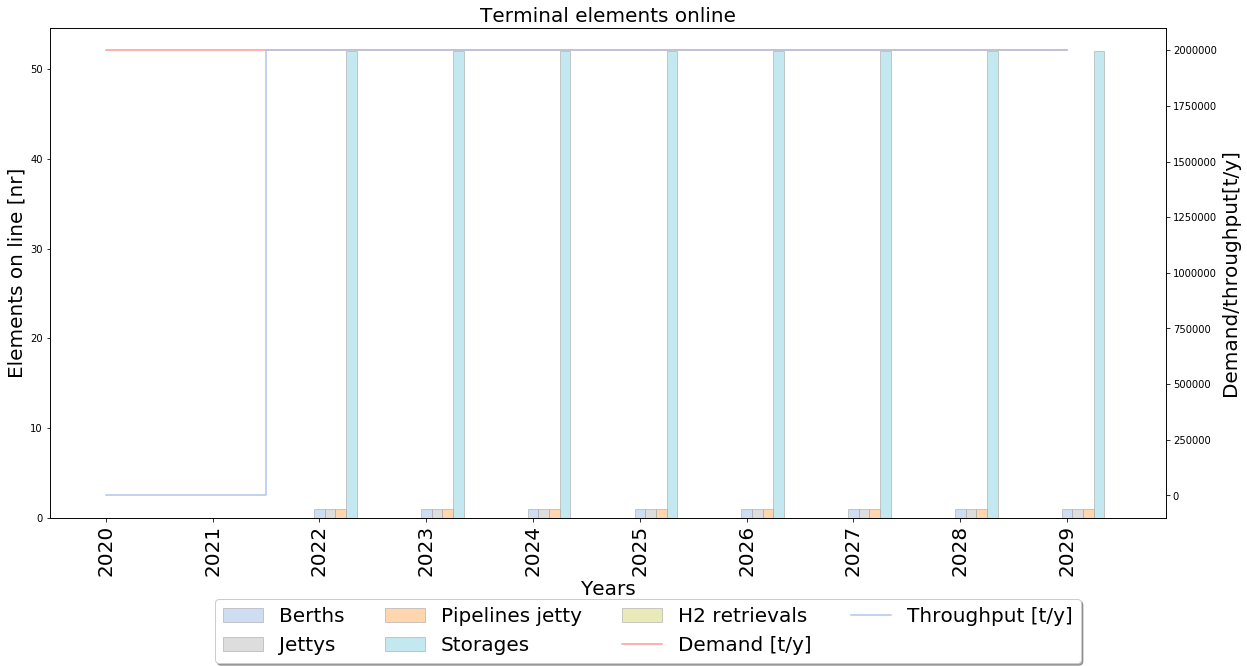

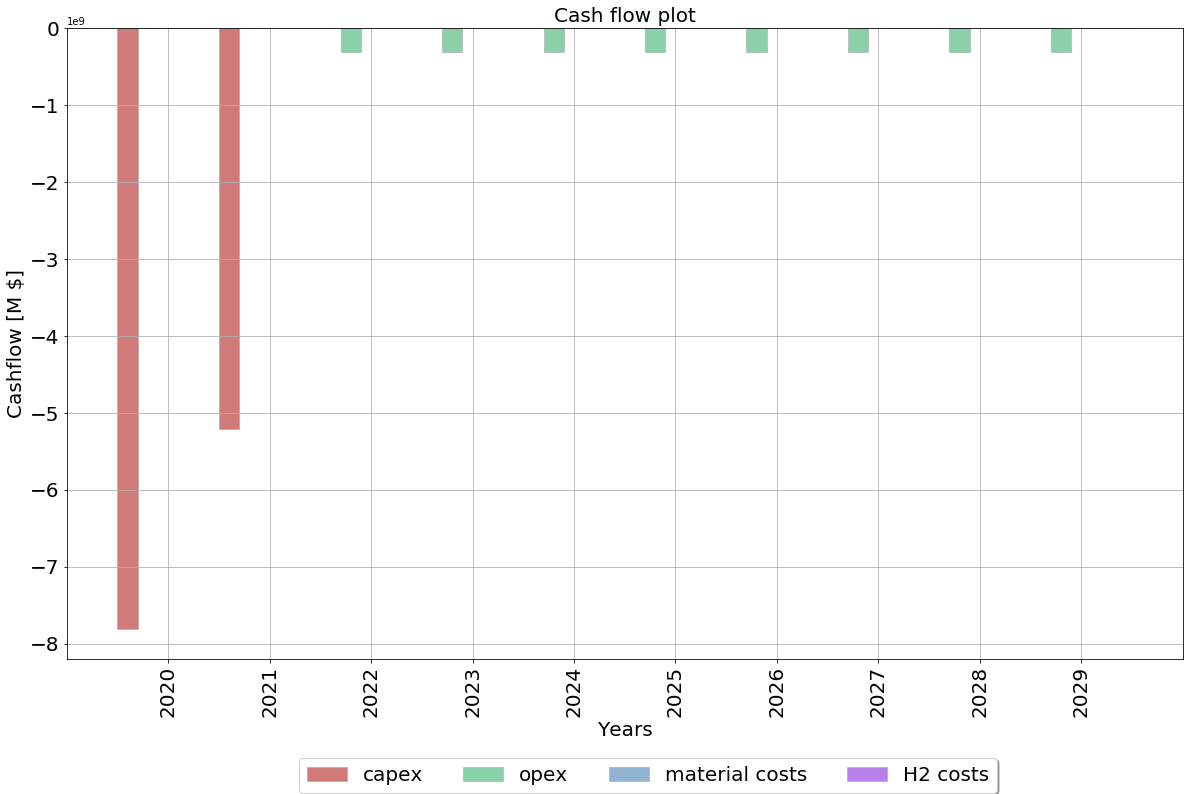

In [30]:
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

self.terminal_elements_plot() #jetty

labour = Labour(**labour_data)
cash_flows_importterminal, cash_flows_WACC_real_importterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_importterminal)

#self.Throughput_capacity_elementplot(2023)

## Export Terminal 

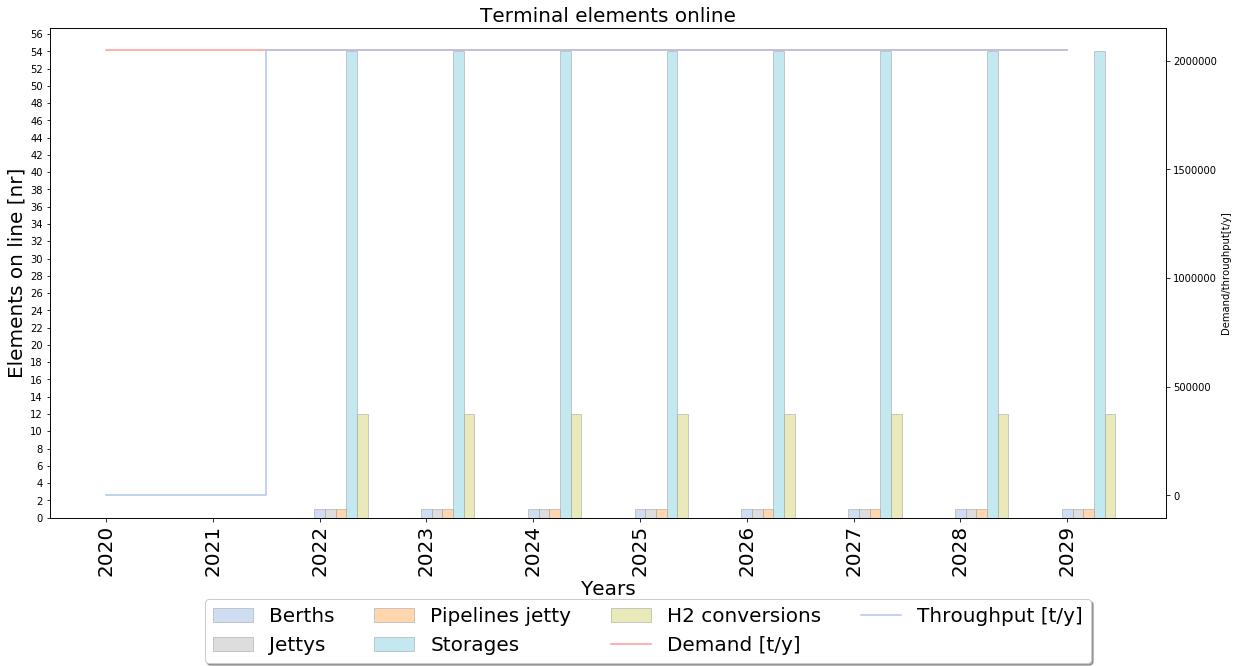

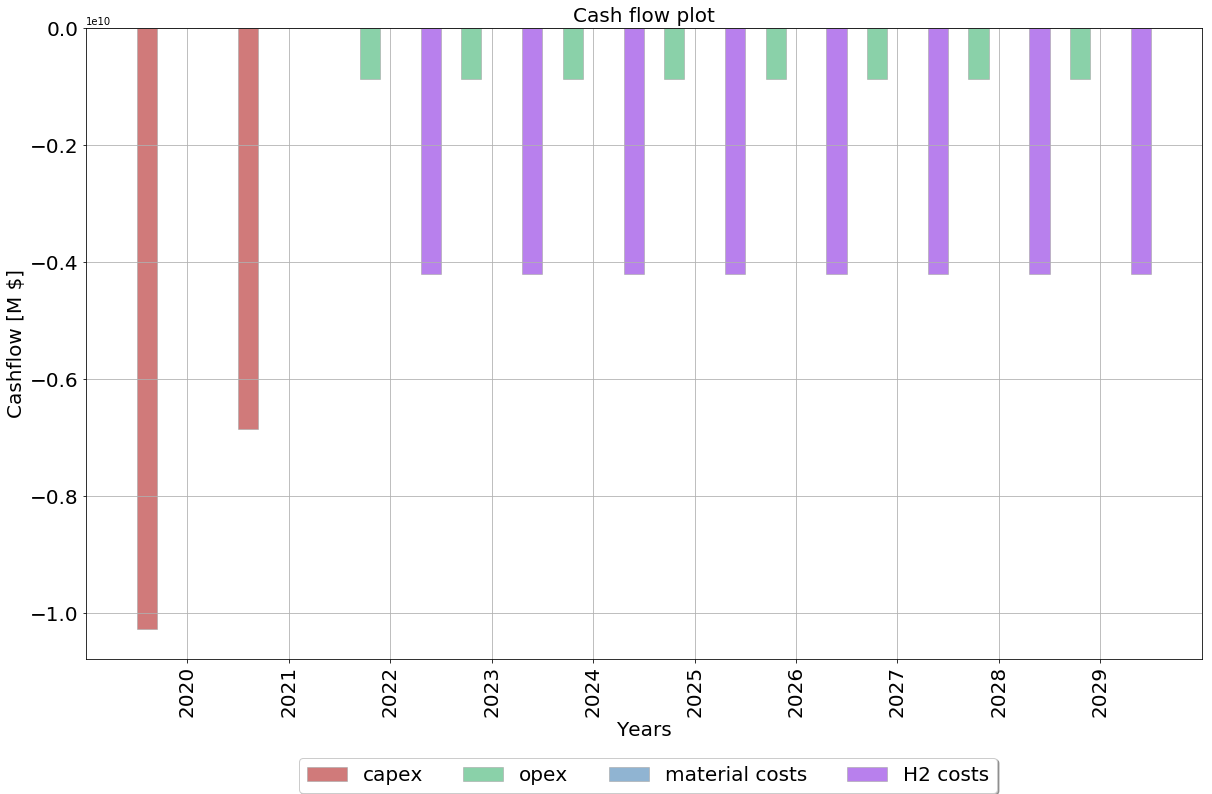

In [31]:
node = 'from_site'
FG.nodes[node]['terminal'].years = years
self = FG.nodes[node]['terminal']

self.terminal_elements_plot() #jetty

# for element in self.elements:
#     print("")
#     print(element.__dict__)

labour = Labour(**labour_data)
cash_flows_exportterminal, cash_flows_WACC_real_exportterminal = opentisim.core.add_cashflow_elements(self, labour)
opentisim.plot.cashflow_plot(self, cash_flows_exportterminal)
#print(cash_flows)

#self.Throughput_capacity_elementplot(2023)

## Transport 

In [32]:
#import transport_plots
from opentisim.liquidbulk.transport_plots import *

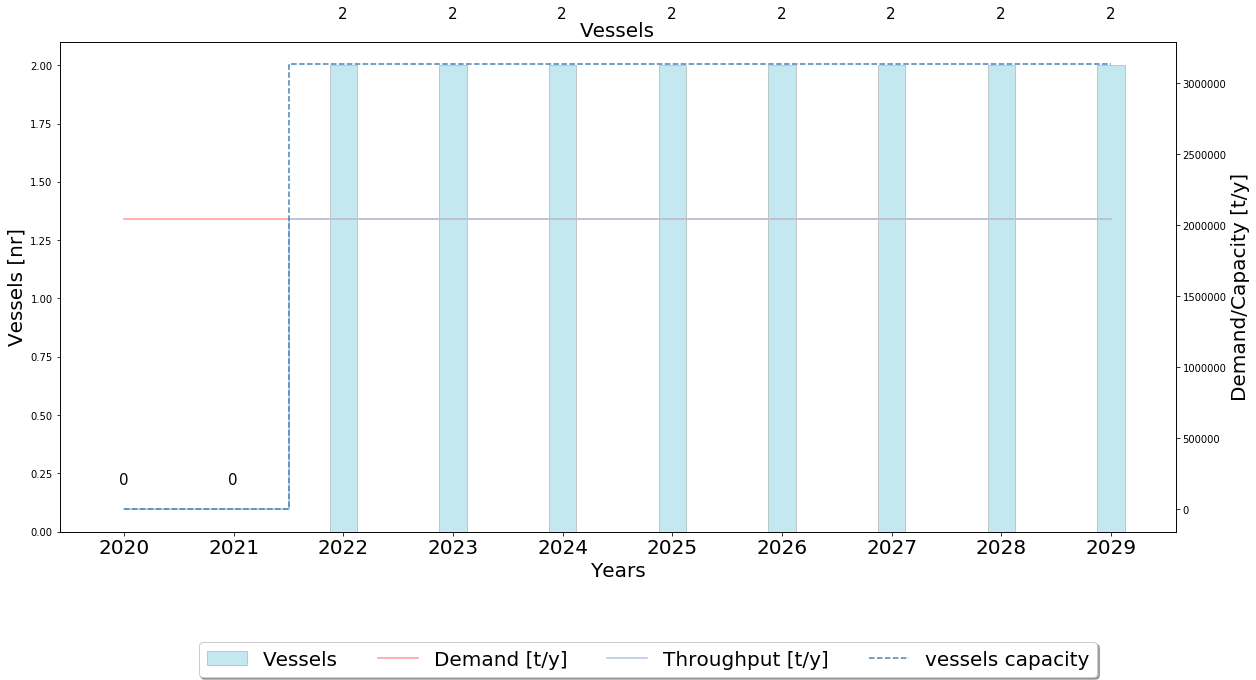

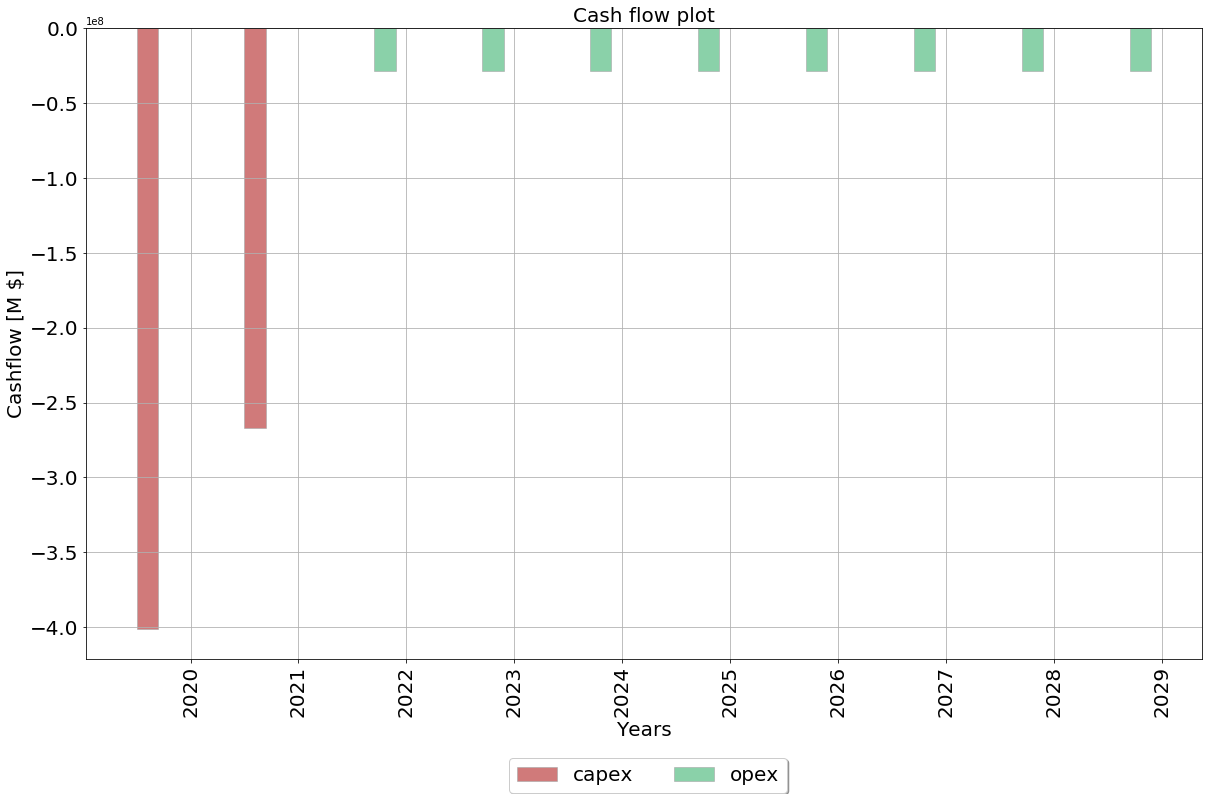

In [33]:
node = 'from_site'
FG.nodes[node]['terminal'].years = years
terminal = FG.nodes[node]['terminal']

dataframe_vessel = df_openclsim

seaborne_transport = vessel_objects(terminal, dataframe_vessel, vessel_defaults, durationdays, numberoftrips)
transport_elements_plot(terminal, seaborne_transport, numberoftrips, width=0.25, alpha=0.6)

cash_flows_seatransport,cash_flows_WACC_real_seatransport = add_cashflow_vessels(terminal, seaborne_transport)
cashflow_plot(cash_flows_seatransport, title='Cash flow plot', width=0.2, alpha=0.6, fontsize=20)

## Total cost price of de Export - Import supply chain 


In [34]:
def costprice_supplychain1(years,Hcontent, cash_flows_importterminal,cash_flows_exportterminal,cash_flows_seatransport):
    throughputsum = 0 

    for year in years:
        throughput_online_des, throughput_terminal_in_des ,throughput_online_jetty_in_des, throughput_online_stor_in_des, throughput_online_plant_in_des, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)
        throughputsum += throughput_online_des

    throughputsum_kg = throughputsum*1000
    throughputsum_kg_H2 = (throughputsum_kg *Hcontent)/100

    capex_import = cash_flows_importterminal['capex']+cash_flows_importterminal['capex_material']
    capex_export = cash_flows_exportterminal['capex']+cash_flows_exportterminal['capex_material']
    capex_transport = cash_flows_seatransport['capex'] 

    capex_tot =  capex_import + capex_export + capex_transport

    opex_import = cash_flows_importterminal['maintenance']+cash_flows_importterminal['insurance'] + cash_flows_importterminal['energy']+ \
                cash_flows_importterminal['labour'] + cash_flows_importterminal['fuel']+cash_flows_importterminal['purchaseH2']+\
                cash_flows_importterminal['purchase_material']

    opex_export = cash_flows_exportterminal['maintenance']+cash_flows_exportterminal['insurance'] + cash_flows_exportterminal['energy']+ \
                cash_flows_exportterminal['labour'] + cash_flows_exportterminal['fuel']+cash_flows_exportterminal['purchaseH2']+\
                cash_flows_exportterminal['purchase_material']

    opex_transport = cash_flows_seatransport['maintenance']+cash_flows_seatransport['insurance'] + \
                cash_flows_seatransport['labour'] + cash_flows_seatransport['fuel']

    opex_tot = opex_import + opex_export + opex_transport 

    costs_tot = capex_tot + opex_tot 

    sum_costs_tot = sum(costs_tot)

    costprice_kgH2 = sum_costs_tot / throughputsum_kg_H2

    costprice_import = sum(capex_import+opex_import)/ throughputsum_kg_H2
    costprice_transport = sum(capex_transport+opex_transport)/ throughputsum_kg_H2
    costprice_export = sum(capex_export+opex_export)/ throughputsum_kg_H2

    return(costprice_kgH2,costprice_import, costprice_transport,costprice_export)

In [35]:
costprice_kgH2_WACC,costprice_import_WACC, costprice_transport_WACC,costprice_export_WACC = costprice_supplychain1(years,Hcontent, cash_flows_WACC_real_importterminal,cash_flows_WACC_real_exportterminal,cash_flows_WACC_real_seatransport)

costprice_kgH2,costprice_import, costprice_transport,costprice_export = costprice_supplychain1(years,Hcontent, cash_flows_importterminal,cash_flows_exportterminal,cash_flows_seatransport)

print('total cost price of supply chain without WACC is', costprice_kgH2, '€/kgH2')
print('total cost price of supply chain with WACC is', costprice_kgH2_WACC, '€/kgH2')
# print('total cost price of import terminal is', costprice_import_WACC, '€/kgH2')
# print('total cost price of transport is', costprice_transport_WACC, '€/kgH2')
# print('total cost price of export terminal is', costprice_export_WACC, '€/kgH2')

total cost price of supply chain without WACC is 4.637932405931755 €/kgH2
total cost price of supply chain with WACC is 3.400383368179668 €/kgH2


## Example Mass Balance for the year 2024

/Users/noor/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.



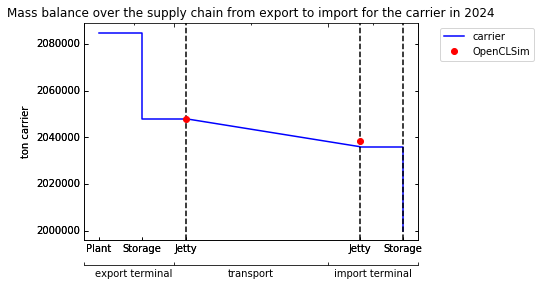

In [36]:
#export terminal 
year = 2024

node = 'from_site'
FG.nodes[node]['terminal'].years = years
exportterminal = FG.nodes[node]['terminal']
throughput_online_ex, throughput_terminal_in_ex ,throughput_online_jetty_in_ex, throughput_online_stor_in_ex, throughput_online_plant_in_ex, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = exportterminal.throughput_elements(year)
        
#import terminal 
node = 'mid_site'
FG.nodes[node]['terminal'].years = years
importterminal = FG.nodes[node]['terminal']
throughput_online_im, throughput_terminal_in_im ,throughput_online_jetty_in_im, throughput_online_stor_in_im, throughput_online_plant_in_im, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = importterminal.throughput_elements(year)


if place == 'decentralized':

    plant_export_in = throughput_online_plant_in_ex
    plant_export_out = throughput_online_stor_in_ex
    stor_export_in = throughput_online_stor_in_ex
    stor_export_out = throughput_online_jetty_in_ex
    jetty_export_in = throughput_online_jetty_in_ex
    jetty_export_out = throughput_online_ex

    jetty_import_in = throughput_online_jetty_in_im
    jetty_import_out =  throughput_online_stor_in_im
    stor_import_in =  throughput_online_stor_in_im
    stor_import_out = throughput_online_im

#     stor_enduse_in = throughput_online_stor_in_end
#     stor_enduse_out = throughput_online_plant_in
#     plant_enduse_in = throughput_online_plant_in
#     plant_enduse_out = throughput_online_end

    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

    fig1 = plt.figure()
    ax1 = SubplotHost(fig1, 111)
    fig1.add_subplot(ax1)

    x = [0,1,2,6,7]#np.array([0,1,2])  #,3,4,5,6,7])

    my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage']

    x1 = [0,0,1,1,2,2]
    y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

    x2 = [2,6]
    y2 = [jetty_export_in,jetty_import_in ]

    x3 = [6,6,7,7]
    y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out ]


    ax1.step(x1, y1, color = 'blue', label = 'carrier')
    ax1.plot(x2,y2,color = 'blue')
    ax1.step(x3,y3,color = 'blue')

    ax1.set_xticks(x)
    ax1.set_xticklabels(my_xticks)

    #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
    ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=6, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=7, color = 'k', linestyle = 'dashed')
    
    index_year = df_openclsim[df_openclsim ['year']==2024].index.values
    level_mid_site_year = df_openclsim ['level to site'][index_year[0]]

    ax1.plot(2,throughput_online_ex, 'ro')
    ax1.plot(6,level_mid_site_year, 'ro', label = 'OpenCLSim')

    # ax1.plot(2,throughput_online_or, 'ro')
    # ax1.plot(6,level_to_site_year, 'ro', label = 'OpenCLSim')

    ax1.set_title('Mass balance over the supply chain from export to import for the carrier in 2024')
    ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
    ax1.yaxis.set_label_text("ton carrier")

    ax2 = ax1.twiny()
    offset = 0, -25 # Position of the second axis
    new_axisline = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
    #ax2.axis["top"].set_visible(False)

    ax2.set_xticks([0, 0.27, 0.73, 1])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.axis["bottom"].minor_ticks.set_ticksize(0)
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.15, 0.5, 0.865]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal']))

    plt.show()
    
    
if place == 'centralized':
    plant_export_in = throughput_online_plant_in_ex
    plant_export_out = throughput_online_stor_in_ex
    stor_export_in = throughput_online_stor_in_ex
    stor_export_out = throughput_online_jetty_in_ex
    jetty_export_in = throughput_online_jetty_in_ex
    jetty_export_out = throughput_online_ex

    jetty_import_in = throughput_online_jetty_in_im
    jetty_import_out =  throughput_online_stor_in_im
    stor_import_in =  throughput_online_stor_in_im
    stor_import_out = throughput_online_plant_in_im
    plant_import_in = throughput_online_plant_in_im
    plant_import_out = throughput_online_im

    
    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

    fig1 = plt.figure()
    ax1 = SubplotHost(fig1, 111)
    fig1.add_subplot(ax1)

    x = [0,1,2,6,7,8]#np.array([0,1,2])  #,3,4,5,6,7])

    my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage', 'Plant']

    x1 = [0,0,1,1,2,2]
    y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

    x2 = [2,6]
    y2 = [jetty_export_in,jetty_import_in ]

    x3 = [6,6,7,7,8,8]
    y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out, plant_import_in, plant_import_out ]


    ax1.step(x1, y1, color = 'blue', label = 'carrier')
    ax1.plot(x2,y2,color = 'blue')
    ax1.step(x3,y3,color = 'blue')

    ax1.set_xticks(x)
    ax1.set_xticklabels(my_xticks)

    #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
    ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=6, color = 'k', linestyle = 'dashed')
    ax1.axvline(x=8, color = 'k', linestyle = 'dashed')
    
    index_year = df_openclsim[df_openclsim ['year']==2024].index.values
    level_mid_site_year = df_openclsim ['level to site'][index_year[0]]

    ax1.plot(2,throughput_online_ex, 'ro')
    ax1.plot(6,level_mid_site_year, 'ro', label = 'OpenCLSim')
    
    ax1.plot(8,throughput_online_im, 'ro')

    # ax1.plot(2,throughput_online_or, 'ro')
    # ax1.plot(6,level_to_site_year, 'ro', label = 'OpenCLSim')

    ax1.set_title('Mass balance over the supply chain from export to import for the carrier in 2024')
    ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
    ax1.yaxis.set_label_text("ton carrier")

    ax2 = ax1.twiny()
    offset = 0, -25 # Position of the second axis
    new_axisline = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
    #ax2.axis["top"].set_visible(False)

    ax2.set_xticks([0, 0.27, 0.73, 1])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.axis["bottom"].minor_ticks.set_ticksize(0)
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.15, 0.5, 0.865]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal']))

    plt.show()



In [37]:
# #import terminal 
# throughput_online_im, throughput_terminal_in_im ,throughput_online_jetty_in_im, throughput_online_stor_in_im, throughput_online_plant_in_im, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

# #export terminal
# throughput_online_ex, throughput_terminal_in_ex,throughput_online_jetty_in_ex, throughput_online_stor_in_ex, throughput_online_plant_in_ex, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
        
# if place == 'decentralized':

#     plant_export_in = throughput_online_plant_in_ex
#     plant_export_out = throughput_online_stor_in_ex
#     stor_export_in = throughput_online_stor_in_ex
#     stor_export_out = throughput_online_jetty_in_ex
#     jetty_export_in = throughput_online_jetty_in_ex
#     jetty_export_out = throughput_online_ex

#     jetty_import_in = throughput_online_jetty_in_im
#     jetty_import_out =  throughput_online_stor_in_im
#     stor_import_in =  throughput_online_stor_in_im
#     stor_import_out = throughput_online_im
    
#     import matplotlib.ticker as ticker
#     from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

#     fig1 = plt.figure()
#     ax1 = SubplotHost(fig1, 111)
#     fig1.add_subplot(ax1)

#     x = [0,1,2,6,7]#np.array([0,1,2])  #,3,4,5,6,7])

#     my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage' ]

#     x1 = [0,0,1,1,2,2]
#     y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

#     x2 = [2,6]
#     y2 = [jetty_export_in,jetty_import_in ]

#     x3 = [6,6,7,7]
#     y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out ]
    
#     ax1.step(x1, y1, color = 'blue', label = 'LH2')
#     ax1.plot(x2,y2,color = 'blue')
#     ax1.step(x3,y3,color = 'blue')

#     ax1.set_xticks(x)
#     ax1.set_xticklabels(my_xticks)

#     #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
#     ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
#     ax1.axvline(x=6, color = 'k', linestyle = 'dashed')
#     ax1.axvline(x=7, color = 'k', linestyle = 'dashed')
    
#     index_year = df_openclsim[df_openclsim ['year']==2024].index.values
#     level_mid_site_year = df_openclsim ['level to site'][index_year[0]]
#     #level_to_site_year = df_openclsim2 ['level to site'][index_year[0]]

# #     ax1.plot(2,throughput_online_ex, 'ro')
# #     ax1.plot(6,level_mid_site_year, 'ro', label = 'OpenCLSim')
    
# #     ax1.plot(7,throughput_online_im, 'ro')
# #     ax1.plot(11,level_to_site_year, 'ro')
#     ax1.set_title('Mass balance over the full supply chain for the carrier in 2024')
#     ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
#     #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
#     ax1.yaxis.set_label_text("ton carrier")

#     ax2 = ax1.twiny()
#     offset = 0, -25 # Position of the second axis
#     new_axisline = ax2.get_grid_helper().new_fixed_axis
#     ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
#     #ax2.axis["top"].set_visible(False)

# #     ax2.set_xticks([0, 0.2, 0.5, 0.581, 0.88, 1])
# #     ax2.xaxis.set_major_formatter(ticker.NullFormatter())
# #     ax2.axis["bottom"].minor_ticks.set_ticksize(0)
# #     ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.1, 0.35, 0.541, 0.731, 00.94]))
# #     ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal', 'transport', 'end-user']))

#     plt.show()

In [38]:
# year = 2024

# #import terminal 
# throughput_online_des, throughput_terminal_in_des ,throughput_online_jetty_in_des, throughput_online_stor_in_des, throughput_online_plant_in_des, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  =  FG.nodes[supplychain.destination]['terminal'].throughput_elements(year)

# #export terminal
# throughput_online_or, throughput_terminal_in_or ,throughput_online_jetty_in_or, throughput_online_stor_in_or, throughput_online_plant_in_or, throughput_planned, throughput_planned_jetty,throughput_planned_pipej, throughput_planned_storage, throughput_planned_plant, Demand,Demand_plant_in, Demand_storage_in, Demand_jetty_in  = FG.nodes[supplychain.origin]['terminal'].throughput_elements(year)
        
# #export terminal 
# plant_export_in = throughput_online_plant_in_or
# plant_export_out = throughput_online_stor_in_or
# stor_export_in = throughput_online_stor_in_or
# stor_export_out = throughput_online_jetty_in_or
# jetty_export_in = throughput_online_jetty_in_or
# jetty_export_out = throughput_online_or

# #import terminal 
# jetty_import_in = throughput_online_jetty_in_des
# jetty_import_out = throughput_online_stor_in_des
# stor_import_in = throughput_online_stor_in_des
# stor_import_out = throughput_online_plant_in_des
# plant_import_in = throughput_online_plant_in_des
# plant_import_out = throughput_online_des

# #transport 
# vessel_in = jetty_export_out
# vessel_out = jetty_import_in

# import matplotlib.ticker as ticker
# from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

# fig1 = plt.figure()
# ax1 = SubplotHost(fig1, 111)
# fig1.add_subplot(ax1)

# x = [0,1,2,6,7,8,9]#np.array([0,1,2])  #,3,4,5,6,7])
# #y = np.array([(plant_export_in, plant_export_out), (stor_export_in,stor_export_out ), (jetty_export_in , jetty_export_out)])
# y = [plant_export_in,stor_export_in, jetty_export_in ,jetty_import_in, stor_import_in, plant_import_in,plant_import_out ]

# my_xticks = ['Plant','Storage','Jetty', 'Jetty', 'Storage', 'Plant','End' ]

# x1 = [0,0,1,1,2,2]
# y1 = [plant_export_in,plant_export_out,stor_export_in,stor_export_out,jetty_export_in,jetty_export_out]

# x2 = [2,6]
# y2 = [jetty_export_in,jetty_import_in ]

# x3 = [6,6,7,7,8,8]
# y3 = [jetty_import_in, jetty_import_out ,stor_import_in , stor_import_out,plant_import_in, plant_import_out    ]

# ax1.step(x1, y1, color = 'blue', label = 'LH2')
# ax1.plot(x2,y2,color = 'blue')
# ax1.step(x3,y3,color = 'blue')
# ax1.set_xticks(x)
# ax1.set_xticklabels(my_xticks)
# #ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
# ax1.axvline(x=2, color = 'k', linestyle = 'dashed')
# ax1.axvline(x=6, color = 'k', linestyle = 'dashed')

# index_year = df_openclsim[df_openclsim ['year']==2024].index.values
# level_to_site_year = df_openclsim ['level to site'][index_year[0]]
# # print(level_to_site_year )
# # print(throughput_online_jetty)
# #print(level_to_site_year)

# ax1.plot(2,throughput_online_or, 'ro')
# ax1.plot(6,level_to_site_year, 'ro', label = 'OpenCLSim')

# ax1.set_title('Mass balance over the supply chain for LH2 in 2024')
# #ax1.set_ylim(0,2_500_000)
# ax1.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# #plt.axvline(x=4, ymin =level_to_site, ymax = capacity_from_site, color = 'red', linewidth = 2)
# ax1.yaxis.set_label_text("ton LH2")

# ax2 = ax1.twiny()
# offset = 0, -25 # Position of the second axis
# new_axisline = ax2.get_grid_helper().new_fixed_axis
# ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
# #ax2.axis["top"].set_visible(False)

# ax2.set_xticks([0.0, 0.3, 0.6, 1.0])
# ax2.xaxis.set_major_formatter(ticker.NullFormatter())
# ax2.axis["bottom"].minor_ticks.set_ticksize(0)
# ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.15, 0.45, 0.8]))
# ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['export terminal','transport', 'import terminal']))

# plt.show()


